In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
from torchvision import transforms
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CucumberDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_folder):
                file_path = os.path.join(class_folder, file_name)
                self.image_paths.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CucumberDataset(root_dir="dataset", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, num_workers=0)


In [2]:
from torchvision.models import ResNet152_Weights
from torchvision import models


def get_model(num_classes, device, learning_rate=0.001):
    model = models.resnet152(weights=ResNet152_Weights.DEFAULT)

    model.fc = nn.Linear(model.fc.in_features, num_classes)

    model = model.to(device)

    for param in model.layer1.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
    )

    return model, loss_fn, optimizer


num_classes = len(dataset.classes)
model, loss_fn, optimizer = get_model(num_classes=num_classes,
                                      device=device, learning_rate=0.001)


In [3]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.01,
                                                 min_lr=1e-5)


def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    x, y = x.to(device), y.to(device)

    prediction = model(x)
    batch_loss = loss_fn(prediction, y)

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return batch_loss.item()


def train_one_epoch(model, dataloader, optimizer, loss_fn):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        prediction = model(x)
        batch_loss = loss_fn(prediction, y)

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += batch_loss.item()

        _, predicted = torch.max(prediction, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


@torch.no_grad()
def validate(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = val_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_accuracy = validate(model, val_loader, criterion)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

    return train_losses, val_losses, train_accuracies, val_accuracies


num_epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs
)


Epoch [1/50]
Train Loss: 0.8258, Train Accuracy: 71.58%
Validation Loss: 0.9142, Validation Accuracy: 77.52%

Epoch [2/50]
Train Loss: 0.3769, Train Accuracy: 87.29%
Validation Loss: 0.3206, Validation Accuracy: 88.76%

Epoch [3/50]
Train Loss: 0.2503, Train Accuracy: 91.37%
Validation Loss: 0.2585, Validation Accuracy: 91.09%

Epoch [4/50]
Train Loss: 0.2500, Train Accuracy: 91.66%
Validation Loss: 1.0132, Validation Accuracy: 81.01%

Epoch [5/50]
Train Loss: 0.2001, Train Accuracy: 92.82%
Validation Loss: 0.4647, Validation Accuracy: 84.50%

Epoch [6/50]
Train Loss: 0.1441, Train Accuracy: 94.76%
Validation Loss: 0.2989, Validation Accuracy: 90.70%

Epoch [7/50]
Train Loss: 0.0956, Train Accuracy: 96.70%
Validation Loss: 0.2160, Validation Accuracy: 93.02%

Epoch [8/50]
Train Loss: 0.0988, Train Accuracy: 97.58%
Validation Loss: 0.1656, Validation Accuracy: 95.74%

Epoch [9/50]
Train Loss: 0.0617, Train Accuracy: 98.16%
Validation Loss: 0.1608, Validation Accuracy: 95.74%

Epoch [10/

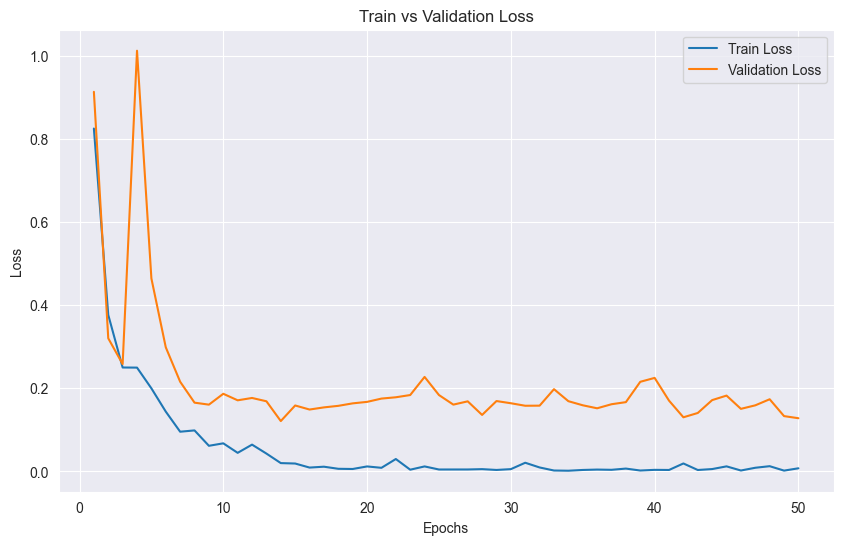

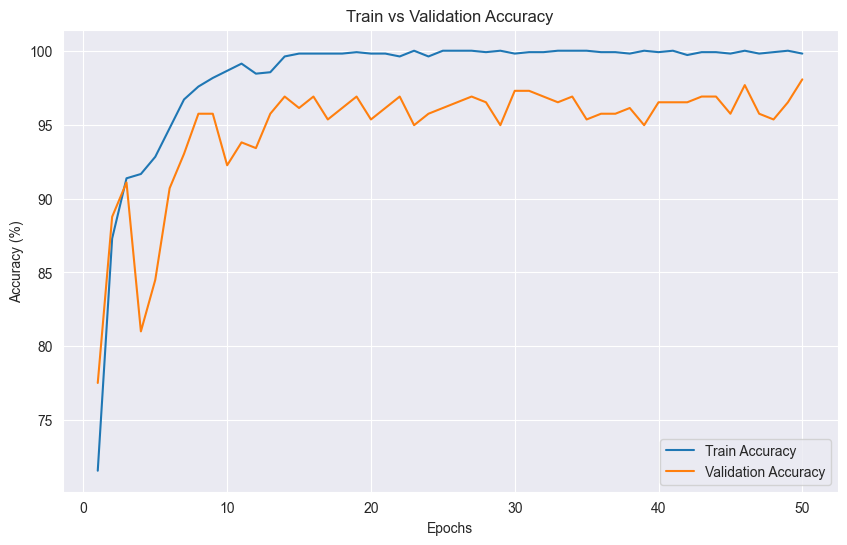

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


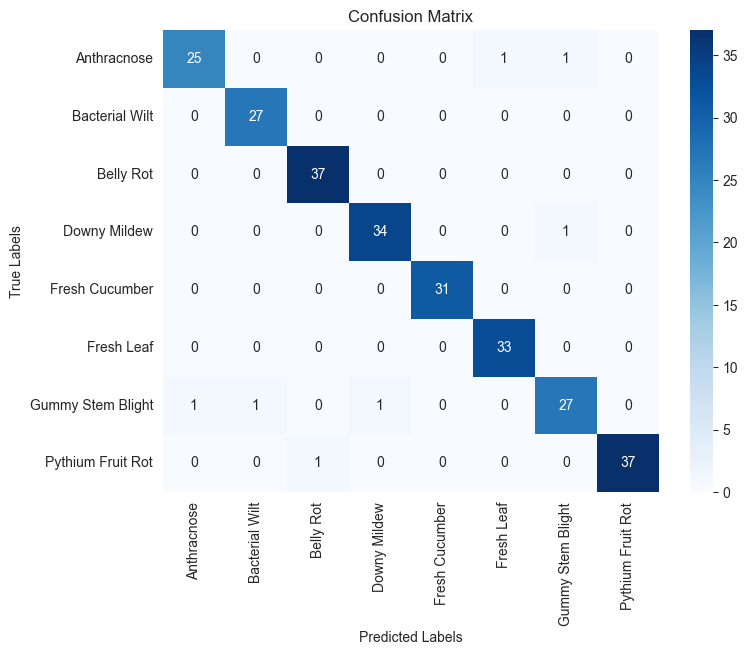

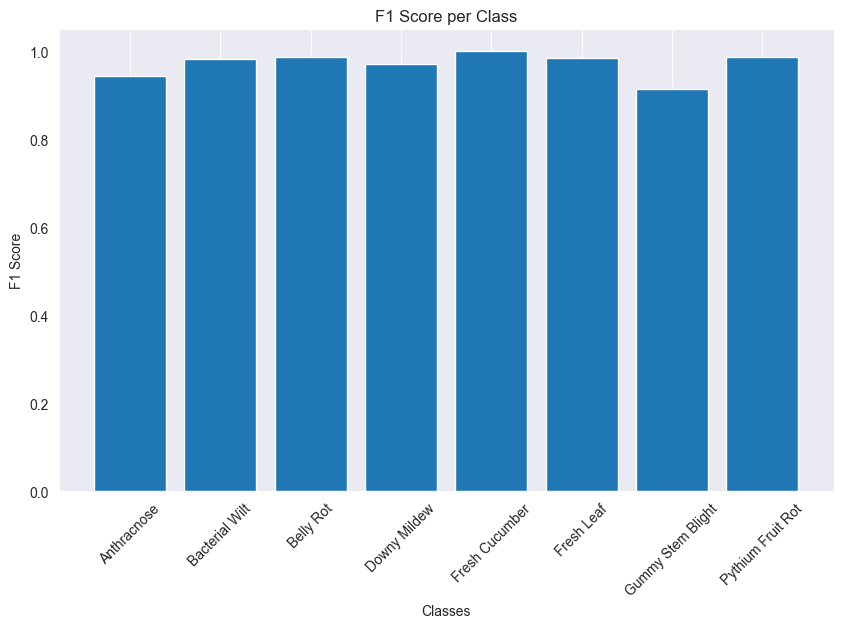

Classification Report:
                    precision    recall  f1-score   support

      Anthracnose       0.96      0.93      0.94        27
   Bacterial Wilt       0.96      1.00      0.98        27
        Belly Rot       0.97      1.00      0.99        37
     Downy Mildew       0.97      0.97      0.97        35
   Fresh Cucumber       1.00      1.00      1.00        31
       Fresh Leaf       0.97      1.00      0.99        33
Gummy Stem Blight       0.93      0.90      0.92        30
Pythium Fruit Rot       1.00      0.97      0.99        38

         accuracy                           0.97       258
        macro avg       0.97      0.97      0.97       258
     weighted avg       0.97      0.97      0.97       258



In [5]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns


@torch.no_grad()
def compute_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm, all_labels, all_preds


cm, all_labels, all_preds = compute_confusion_matrix(model, val_loader)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

f1 = f1_score(all_labels, all_preds, average=None)
plt.figure(figsize=(10, 6))
plt.bar(dataset.classes, f1)
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=dataset.classes))

In [8]:
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Model f_1 score: {f1}")

Model f_1 score: 0.9712881471436234


In [1]:
!ls ./dataset

Anthracnose
Bacterial Wilt
Belly Rot
Downy Mildew
Fresh Cucumber
Fresh Leaf
Gummy Stem Blight
Pythium Fruit Rot


Class labels: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']


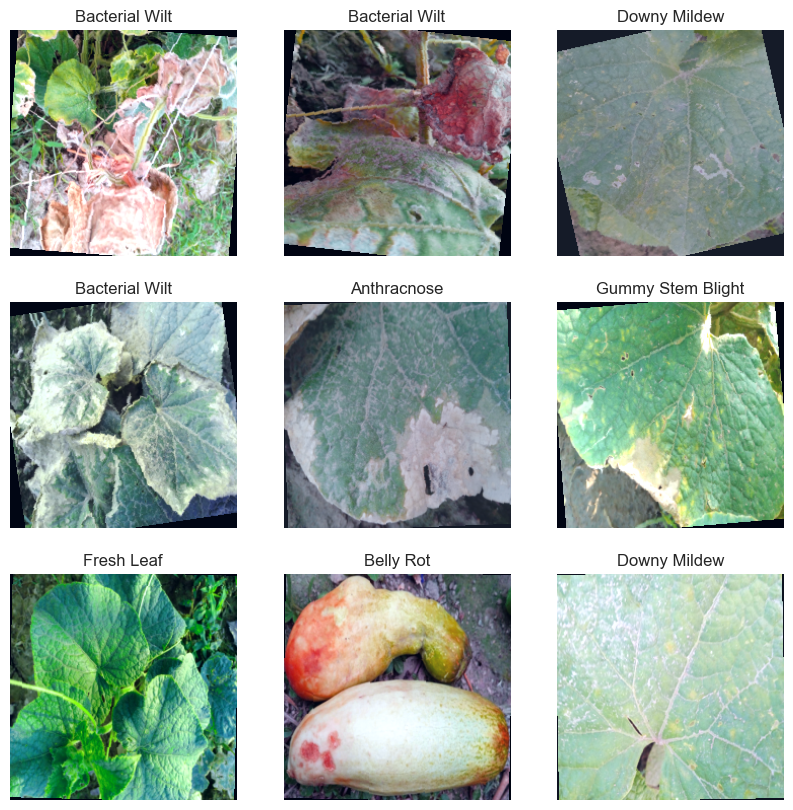

In [11]:
import matplotlib.pyplot as plt
import numpy as np

class_labels = dataset.classes
print("Class labels:", class_labels)

images, labels = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img * 0.229 + 0.485)  #
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    label_idx = labels[i].item()
    plt.title(class_labels[label_idx])
    plt.axis('off')
plt.show()
